# Calculating Climatology and Departures from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 11/07/24 [xcdat v0.7.3]

Related APIs:

- [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)
- [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)


## Overview

Suppose we're working with an `"ersstv5"` dataset (NOAA’s Extended Reconstructed Sea Surface Temperature monthly averages) with time from 1970-01-01 to 2015-01-01.

1. We want to calculate the annual and seasonal cycle climatologies and departures using this file.
2. We want to resample it to hourly frequency and calculate the daily cycle climatologies and departures.

The data used in this example can be found in the [xarray-data repository](https://github.com/pydata/xarray-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xcdat as xc

## 1. Open Sample Datasets


In [3]:
ds = xc.tutorial.open_dataset("ersstv5", use_cftime=True)

### File 1: Monthly Frequency


In [4]:
ds_monthly = ds.copy()

ds_monthly

<xarray.Dataset> Size: 40MB
Dimensions:    (lat: 89, lon: 180, time: 624, bnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) object 5kB 1970-01-01 00:00:00 ... 2021-12-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 10kB 1970-01-01 00:00:00 ... 2022-01-01 00...
    sst        (time, lat, lon) float32 40MB ...
    lon_bnds   (lon, bnds) float32 1kB -1.0 1.0 1.0 3.0 ... 357.0 357.0 359.0
    lat_bnds   (lat, bnds) float32 712B 89.0 87.0 87.0 ... -87.0 -87.0 -89.0
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

### 2: Hourly Frequency

We're going to resample the dataset to hourly frequency.


In [5]:
ds_hourly = ds.sel(time=slice("2010-01-01", "2015-01-01"))
ds_hourly = ds_hourly.resample(time="h").mean()

ds_hourly

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 89, lon: 180, time: 43825, bnds: 2)
Coordinates:
  * lat       (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon       (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time      (time) object 351kB 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    sst       (time, lat, lon) float32 3GB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
    lon_bnds  (time, lon, bnds) float32 63MB -1.0 1.0 1.0 ... 357.0 357.0 359.0
    lat_bnds  (time, lat, bnds) float32 31MB 89.0 87.0 87.0 ... -87.0 -89.0
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

## 2. Calculate Climatology

Related API: [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)

In this example, we will be calculating the weighted climatology of the `sst` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.
- If desired, use the `reference_period` argument to calculate a climatology based on a
  climatological reference period (a subset of the entire time series). If no value is
  provided, the climatological reference period will be the full period covered by the
  dataset.


### Seasonal Climatology

**Groups time coordinates by season**

The `season_config` dictionary keyword argument can be passed to `.climatology()` for more granular configuration. We will be sticking with the default settings.


In [6]:
season_climo = ds_monthly.temporal.climatology(
    "sst",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [7]:
season_climo.sst

<xarray.DataArray 'sst' (time: 4, lat: 89, lon: 180)> Size: 513kB
array([[[-1.79981625, -1.79985297, -1.79994214, ..., -1.79991531,
         -1.79986632, -1.79981446],
        [-1.79983902, -1.79991055, -1.7999984 , ..., -1.7999984 ,
         -1.79992783, -1.79984879],
        [-1.7999984 , -1.7999984 , -1.7999984 , ..., -1.7999984 ,
         -1.7999984 , -1.7999984 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999971, -1.79999971, -1.79999971, ..., -1.79999971,
         -1.79999971, -1.79999971],
        [-1.79999971, -1.79999971, -1.79999971, ..., -1.79999971,
         -1.79999971, -1.79999971],
        [-1.79999971, -1.79999971, -1.79999971, ..., -1.79999971,
         -1.79999971, -1.79999971],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79780686, -1.79789853, -1.79790592, ..., -1.79814029,
         -1.79788494, -1.79771841],
        [-1.79790151, -1.79761696, -1.79740644, ..., -1.79935026,
         -1.79849136, -1.79822123],
        [-1.79993308, -1.79919863, -1.79871511, ..., -1.79943478,
         -1.7996434 , -1.799842  ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) object 32B 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes: (12/15)
    long_name:            Monthly Means of Sea Surface Temperature
    units:                degC
    var_desc:             Sea Surface Temperature
    level_desc:           Surface
    statistic:            Mean
    dataset:              NOAA Extended Reconstructed SST V5
    ...                   ...
    operation:            temporal_avg
    mode:                 climatology
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

In [8]:
season_climo["sst"][0]

<xarray.DataArray 'sst' (lat: 89, lon: 180)> Size: 128kB
array([[-1.79981625, -1.79985297, -1.79994214, ..., -1.79991531,
        -1.79986632, -1.79981446],
       [-1.79983902, -1.79991055, -1.7999984 , ..., -1.7999984 ,
        -1.79992783, -1.79984879],
       [-1.7999984 , -1.7999984 , -1.7999984 , ..., -1.7999984 ,
        -1.7999984 , -1.7999984 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time     object 8B 0001-01-01 00:00:00
Attributes: (12/15)
    long_name:            Monthly Means of Sea Surface Temperature
    units:                degC
    var_desc:             Sea Surface Temperature
    level_desc:           Surface
    statistic:            Mean
    dataset:              NOAA Extended Reconstructed SST V5
    ...                   ...
    operation:            temporal_avg
    mode:                 climatology
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

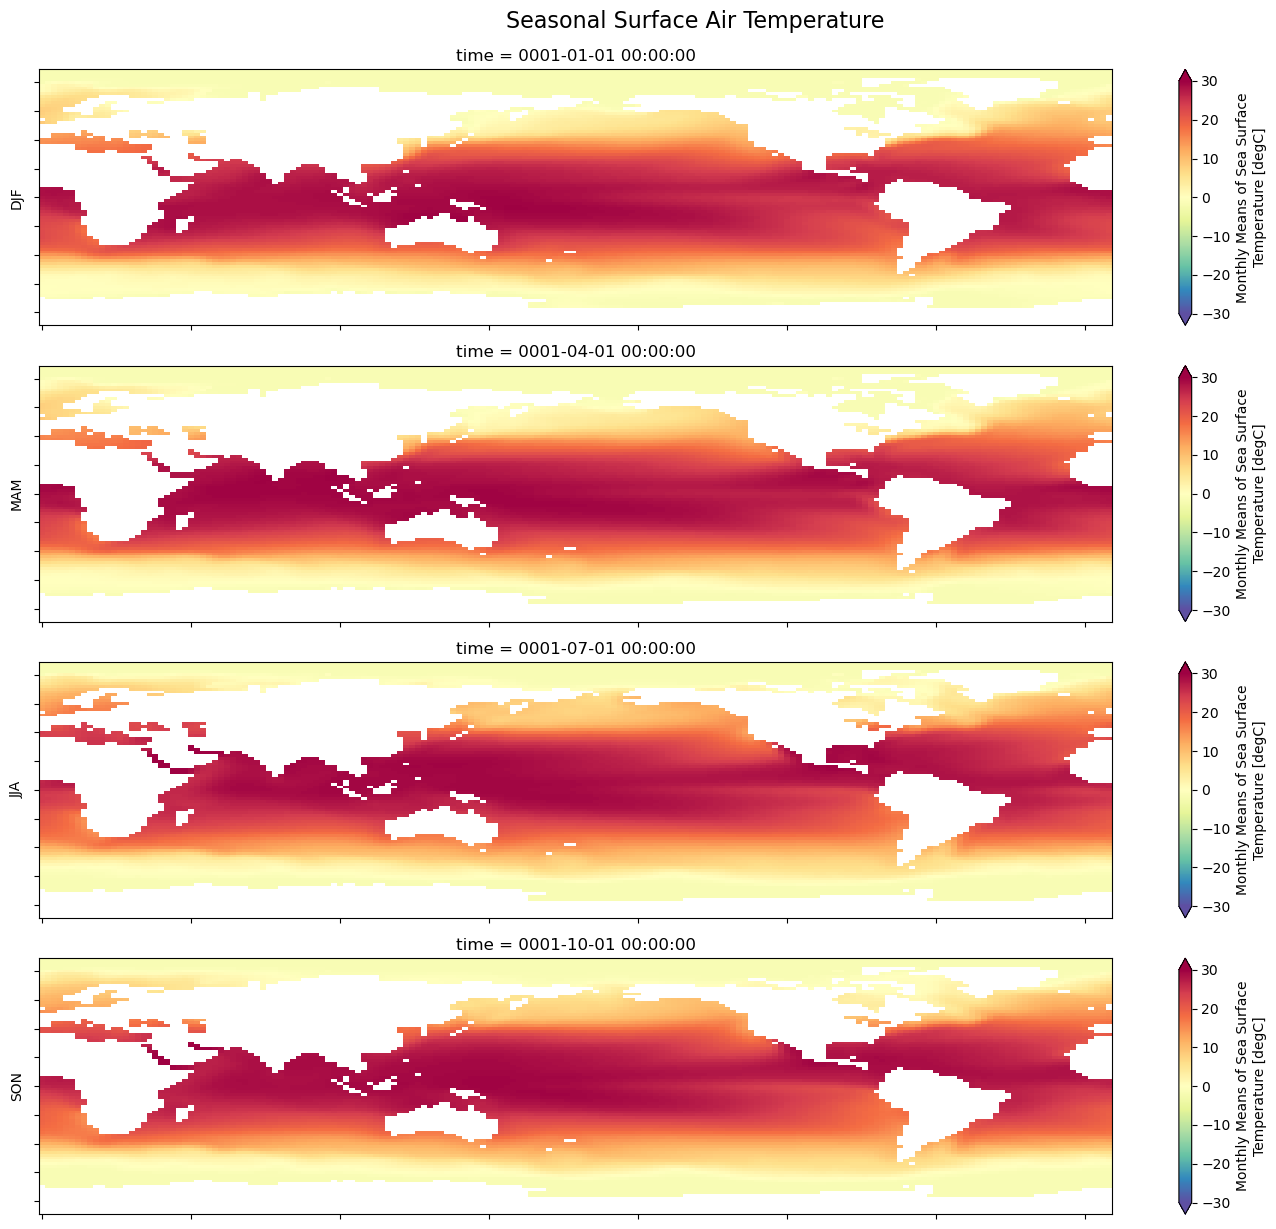

In [ ]:
notnull = pd.notnull(season_climo["sst"][0])
sst_season = season_climo.sst

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    sst_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

Notice that the time coordinates are `cftime` objects, with each season ("DJF", "MAM", "JJA", and "SON") represented by its middle month.

`cftime` objects are used because the time coordinates are outside the Timestamp-valid range (approximately between years 1678 and 2262).

- More info here: https://xarray.pydata.org/en/v2022.03.0/user-guide/weather-climate.html#non-standard-calendars-and-dates-outside-the-timestamp-valid-range


In [30]:
season_climo.time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array([cftime.DatetimeProlepticGregorian(1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 10, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 32B 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81204.]
    bounds:           time_bnds

### Custom Seasonal Climatology

**Groups time coordinates by season**

To calculate custom seasonal cycle climatology, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [31]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JunJulAug"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]

c_season_climo = ds_monthly.temporal.climatology(
    "sst",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [32]:
c_season_climo.sst

<xarray.DataArray 'sst' (time: 4, lat: 89, lon: 180)> Size: 513kB
array([[[-1.80000091, -1.80000091, -1.80000091, ..., -1.80000091,
         -1.80000091, -1.80000091],
        [-1.80000091, -1.80000091, -1.80000091, ..., -1.80000091,
         -1.80000091, -1.80000091],
        [-1.80000091, -1.80000091, -1.80000091, ..., -1.80000091,
         -1.80000091, -1.80000091],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        [-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        [-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79765451, -1.79778063, -1.79787385, ..., -1.79807961,
         -1.79777992, -1.79756546],
        [-1.79777014, -1.79755759, -1.79743385, ..., -1.79935658,
         -1.79843915, -1.79809582],
        [-1.79993296, -1.7992065 , -1.79872835, ..., -1.79944003,
         -1.79964638, -1.79984283],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) object 32B 0001-02-01 00:00:00 ... 0001-11-01 00:00:00
Attributes: (12/14)
    long_name:       Monthly Means of Sea Surface Temperature
    units:           degC
    var_desc:        Sea Surface Temperature
    level_desc:      Surface
    statistic:       Mean
    dataset:         NOAA Extended Reconstructed SST V5
    ...              ...
    valid_range:     [-1.8 45. ]
    operation:       temporal_avg
    mode:            climatology
    freq:            season
    weighted:        True
    custom_seasons:  ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNovDec']

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

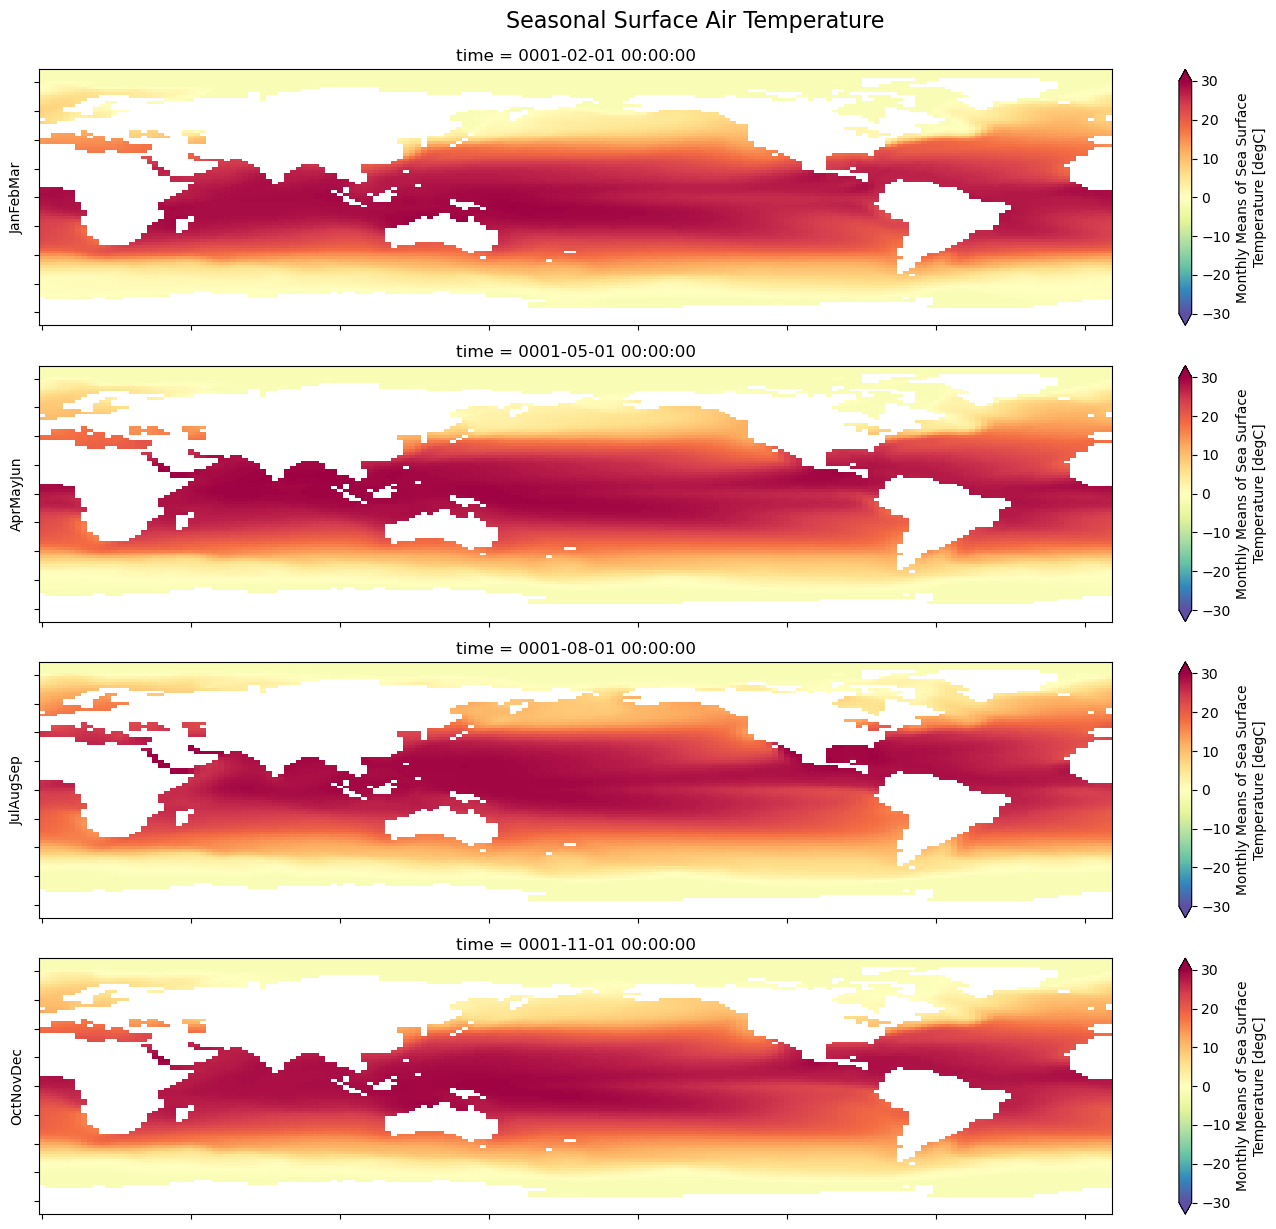

In [33]:
notnull = pd.notnull(c_season_climo["sst"][0])
sst_c_season = c_season_climo.sst

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(sst_c_season.attrs["custom_seasons"]):
    sst_c_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

### Annual Climatology

**Groups time coordinates by month**


In [34]:
annual_climo = ds_monthly.temporal.climatology("sst", freq="month", weighted=True)

In [35]:
annual_climo.sst

<xarray.DataArray 'sst' (time: 12, lat: 89, lon: 180)> Size: 2MB
array([[[-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        [-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        [-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999948, -1.79999948, -1.79999948, ..., -1.79999948,
         -1.79999948, -1.79999948],
        [-1.79999948, -1.79999948, -1.79999948, ..., -1.79999948,
         -1.79999948, -1.79999948],
        [-1.79999948, -1.79999948, -1.79999948, ..., -1.79999948,
         -1.79999948, -1.79999948],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.7994802 , -1.79958522, -1.79983997, ..., -1.7997632 ,
         -1.79962325, -1.79947531],
        [-1.79954541, -1.79974973, -1.80000055, ..., -1.80000055,
         -1.79979908, -1.79957318],
        [-1.80000055, -1.80000055, -1.80000055, ..., -1.80000055,
         -1.80000055, -1.80000055],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes: (12/13)
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    ...            ...
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    operation:     temporal_avg
    mode:          climatology
    freq:          month
    weighted:      True

### Daily Climatology

**Groups time coordinates by month and day.**

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [36]:
daily_climo = ds_hourly.temporal.climatology("sst", freq="day", weighted=True)

2024-10-30 14:46:17,025 [WARNING]: temporal.py(_set_data_var_attrs:869) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2024-10-30 14:46:17,025 [WARNING]: temporal.py(_set_data_var_attrs:869) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.


KeyError: "No variable named 'time_bnds'. Variables on the dataset include ['lat', 'lon', 'time', 'sst', 'lon_bnds', 'lat_bnds']"

In [ ]:
daily_climo.sst

## 3. Calculate Departures (Anomalies)

Related API: [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)

In this example, we will be calculating the weighted departures of the `sst` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- What are anomalies?
  - In climatology, “anomalies” refer to the difference between the value during a given time
    interval (e.g., the January average surface air temperature) and the long-term average value for
    that time interval (e.g., the average surface temperature over the last 30 Januaries).
- How is the climatology calculated?
  - In the departures API, the reference climatology is calculated internally so there is no need to pass one to this method.
  - You can still calculate the reference climatology using the climatology API.
  - If desired, use the `reference_period` argument to calculate anomalies relative to a
    climatological reference period (a subset of the entire time series). If no value is
    provided, the climatological reference period will be the full period covered by the
    dataset.
- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.


### Seasonal Anomalies

The `season_config` dictionary keyword argument can be passed to `.departures()` for more granular configuration. We will be sticking with the default settings.


In [ ]:
season_departures = ds_monthly.temporal.departures(
    "sst",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [ ]:
season_departures.sst

### Custom Seasonal Anomalies

To calculate custom seasonal cycle anomalies, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [ ]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JulAugSep"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]
c_season_departs = ds_monthly.temporal.departures(
    "sst",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [ ]:
c_season_departs.sst

### Annual Anomalies


In [ ]:
annual_departures = ds_monthly.temporal.departures("sst", freq="month", weighted=True)

In [ ]:
annual_departures.sst

### Daily Anomalies

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [ ]:
daily_departures = ds_hourly.temporal.departures("sst", freq="day", weighted=True)

In [ ]:
daily_departures.sst